#Clasificación para datos no etiquetados y datos etiquetados.

###Objetivo del proyecto


El trabajo tiene como objetivo principal desarrollar un sistema de clasificación para muestras de vino mediante técnicas de aprendizaje automático.
Se va a dividir en dos partes.
El dataset contiene datos etiquetados, pero para la primera parte se implementarán algoritmos de clustering no supervisado utilizando exclusivamente las variables fisicoquímicas (como alcohol, ácido málico, ceniza, alcalinidad, magnesio, fenoles, flavonoides, entre otras), prescindiendo de la variable categórica que corresponde al etiquetado.

En la segunda parte, se recuperará la variable categórica y se desarrollará un modelo predictivo basado en Random Forest que permitirá clasificar nuevas muestras de vino en las categorías correspondientes.

El objetivo es ver es si las características fisicoquímicas analizadas poseen un extraordinario poder discriminativo inherente, capaz de separar las clases de vino incluso sin referencia al etiquetado original y compararlo con cuando se entrena con un algoritmo supervizado.

###Sobre el Dataset

El conjunto de datos Wine contiene 178 observaciones distribuidas entre tres clases (correspondientes a tres diferentes cultivares de vid), con 59 muestras para la clase 1, 71 para la clase 2 y 48 para la clase 3. Cada registro incluye trece variables numéricas: alcohol, ácido málico, ceniza, alcalinidad de la ceniza, magnesio, fenoles totales, flavonoides, fenoles no flavonoides, proantocianinas, intensidad de color, matiz, OD280/OD315 de vinos diluidos y prolina. Todas estas variables corresponden a resultados de análisis químicos realizados en cada vino. Adicionalmente, contiene una variable categórica que indica la clase (cultivar) a la que pertenece cada observación. Este dataset presenta características discriminantes entre las tres clases, aunque con diferentes grados de separabilidad en el espacio multidimensional de características.


In [125]:
import pandas as pd
from pandasql import sqldf
import sklearn
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, cohen_kappa_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV






wine = load_wine()
df = pd.DataFrame(data=wine.data, columns=wine.feature_names)
df['species'] = pd.Categorical.from_codes(wine.target, wine.target_names)


In [126]:

print("Columnas en el dataset:")
print(df.columns.tolist())
print("\n")

print("Primeras filas del dataset:")
print(df.head())
print("\n")



Columnas en el dataset:
['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline', 'species']


Primeras filas del dataset:
   alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24            

##Enfoque No supervizado
Se desarrrollará un modelo de clasificación utilizando técnicas no supervisadas, específicamente k-means en combinación con análisis de componentes principales (PCA).


In [127]:
consulta = """ SELECT
    `alcohol`,
    `malic_acid`,
    `ash`,
    `alcalinity_of_ash`,
    `magnesium`,
    `total_phenols`,
    `flavanoids`,
    `nonflavanoid_phenols`,
    `proanthocyanins`,
    `color_intensity`,
    `hue`,
    `od280/od315_of_diluted_wines`,
    `proline`
FROM
    df """

wineNoSupervizado = sqldf(consulta)

print(wineNoSupervizado.shape[0])

wineNoSupervizado = wineNoSupervizado.dropna()
print(wineNoSupervizado.shape[0])

wineNoSupervizado.head()








178
178


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [128]:

wineNoSupervizado.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [129]:
#Voy a normalizar haciendo z-score


wineNoSupervizadoNormalizado = StandardScaler().fit_transform(wineNoSupervizado)



In [130]:
##Ahora calculo la matriz de covarianza y sus autovalores y autovectores y los ordeno.


# Calcular la matriz de covarianza
cov_matrix = np.cov(wineNoSupervizadoNormalizado, rowvar=False)

# Calcular autovalores y autovectores
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# Los ordeno de mayor a menor
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

Antes de realizar PCA quiero ver cuánta información se pierde en función de la cantidad de autovectores escojidos.

In [131]:
# 6. Calcular varianza explicada e información perdida
varianza_explicada = eigenvalues / np.sum(eigenvalues)
varianza_acumulada = np.cumsum(varianza_explicada)
informacion_perdida = (1 - varianza_acumulada[k-1]) * 100

Text(3.1, 0.51, '50% de varianza explicada')

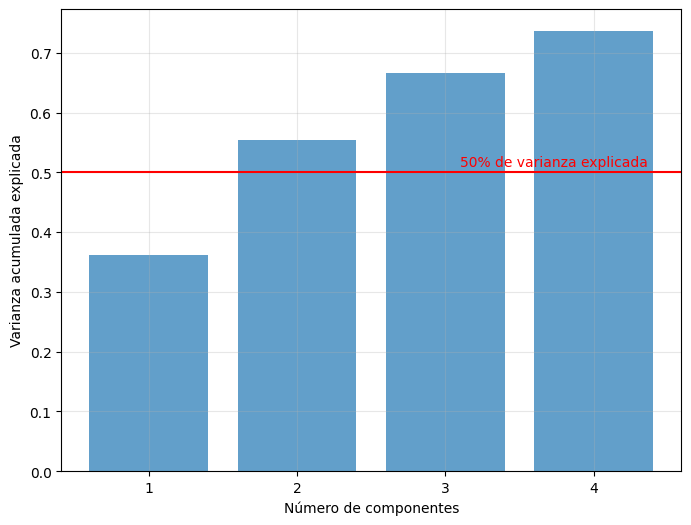

In [132]:
plt.figure(figsize=(8, 6))
plt.bar(range(1, 5), varianza_acumulada[:4], alpha=0.7)
plt.xlabel('Número de componentes')
plt.ylabel('Varianza acumulada explicada')
plt.axhline(y=0.5, color='r', linestyle='-')  # Línea de referencia (95%)
plt.xticks(range(1, 5))
plt.grid(True, alpha=0.3)
plt.text(3.1, 0.51, '50% de varianza explicada', color='red', fontsize=10)


Noto que con 2 componentes principales se preserva aproximadamente el 50% de la varianza total del conjunto de datos. Verificaré el valor exacto de la varianza acumulada explicada.

Ahora me fijo exactamente cuánto mantiene.

In [133]:
varianza_comp_2 = varianza_acumulada[1]

# Conversión a porcentaje
porcentaje_varianza = varianza_comp_2 * 100

# Imprimir los resultados en formato más detallado
print("La varianza explicada con 2 componentes es " + str(round(porcentaje_varianza, 2)) + "%.")


La varianza explicada con 2 componentes es 55.41%.


In [134]:
#Escojo la cantidad de valores principales y los proyecto
k = 2  # o el número deseado
cantidadDeComponentes = eigenvectors[:, :k]

proyeccion = np.dot(wineNoSupervizadoNormalizado, cantidadDeComponentes)

Ahora veo que tanto impacta en cada componente principal los distintos atributos.

In [135]:
# Calcular contribución normalizada (porcentaje) de cada variable a cada componente principal
# Los coeficientes al cuadrado representan la proporción de varianza explicada por cada variable
contrib_comp1 = eigenvectors[:, 0]**2

contrib_comp1 = contrib_comp1 / np.sum(contrib_comp1) * 100

contrib_comp2 = eigenvectors[:, 1]**2
contrib_comp2 = contrib_comp2 / np.sum(contrib_comp2) * 100

feature_names = ['Alcohol', 'Malic Acid', 'Ash', 'Alcalinity of Ash', 'Magnesium',
                'Total Phenols', 'Flavanoids', 'Nonflavanoid Phenols',
                'Proanthocyanins', 'Color Intensity', 'Hue',
                'OD280/OD315 of Diluted Wines', 'Proline']  # Ajustado para el dataset de vino

print("Contribución de cada variable a la primera componente principal:")
for i in range(len(feature_names)):
    print("- " + feature_names[i] + ": " + str(round(contrib_comp1[i], 2)) + "%")

print("\nContribución de cada variable a la segunda componente principal:")
for i in range(len(feature_names)):
    print("- " + feature_names[i] + ": " + str(round(contrib_comp2[i], 2)) + "%")

Contribución de cada variable a la primera componente principal:
- Alcohol: 2.08%
- Malic Acid: 6.01%
- Ash: 0.0%
- Alcalinity of Ash: 5.73%
- Magnesium: 2.02%
- Total Phenols: 15.58%
- Flavanoids: 17.89%
- Nonflavanoid Phenols: 8.91%
- Proanthocyanins: 9.82%
- Color Intensity: 0.79%
- Hue: 8.8%
- OD280/OD315 of Diluted Wines: 14.15%
- Proline: 8.22%

Contribución de cada variable a la segunda componente principal:
- Alcohol: 23.39%
- Malic Acid: 5.06%
- Ash: 9.99%
- Alcalinity of Ash: 0.01%
- Magnesium: 8.98%
- Total Phenols: 0.42%
- Flavanoids: 0.0%
- Nonflavanoid Phenols: 0.08%
- Proanthocyanins: 0.15%
- Color Intensity: 28.09%
- Hue: 7.8%
- OD280/OD315 of Diluted Wines: 2.71%
- Proline: 13.32%


La primera componente principal está principalmente explicada por Flavanoids (17.89%), Total Phenols (15.58%), OD280/OD315 of Diluted Wines (14.15%), Proanthocyanins (9.82%) y Nonflavanoid Phenols (8.91%).

La segunda componente principal está principalmente explicada por Color Intensity (28.09%), Alcohol (23.39%), Proline (13.32%), Ash (9.99%) y Magnesium (8.98%).

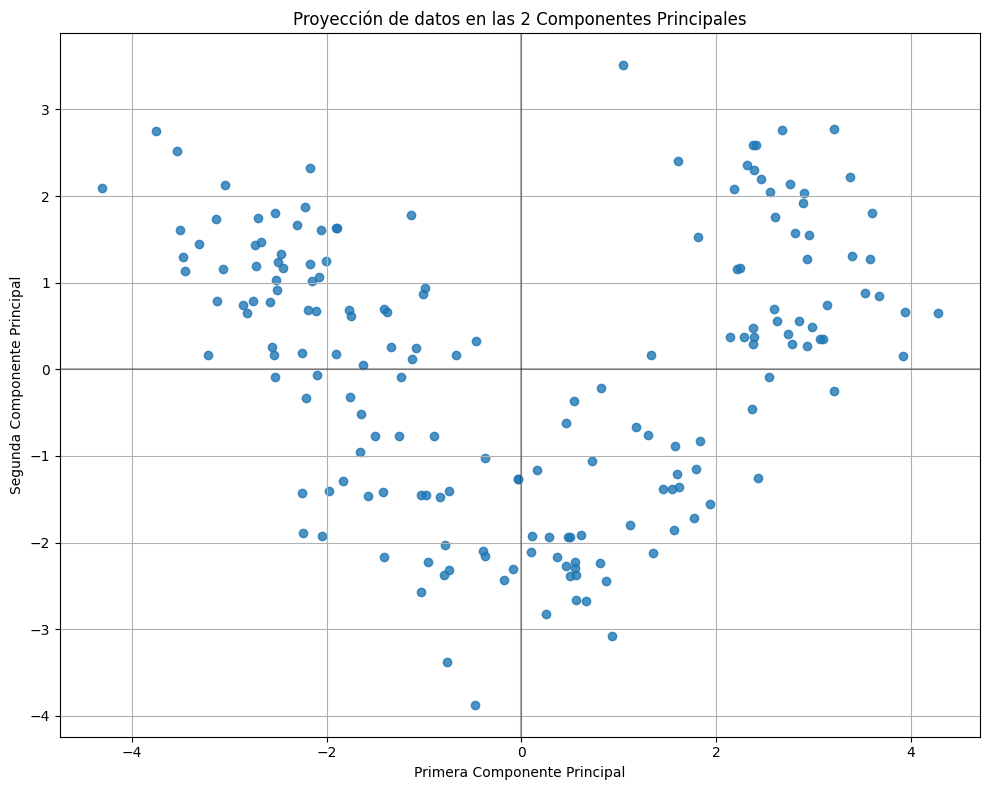

In [136]:
plt.figure(figsize=(10, 8))
plt.scatter(proyeccion[:, 0], proyeccion[:, 1], alpha=0.8)
plt.grid(True)
plt.xlabel('Primera Componente Principal')
plt.ylabel('Segunda Componente Principal')
plt.title('Proyección de datos en las 2 Componentes Principales')

plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

Ahora que tenemos la imagen proyectada, vamos a usar k-Means, escogiendo que K sea igual a 3.

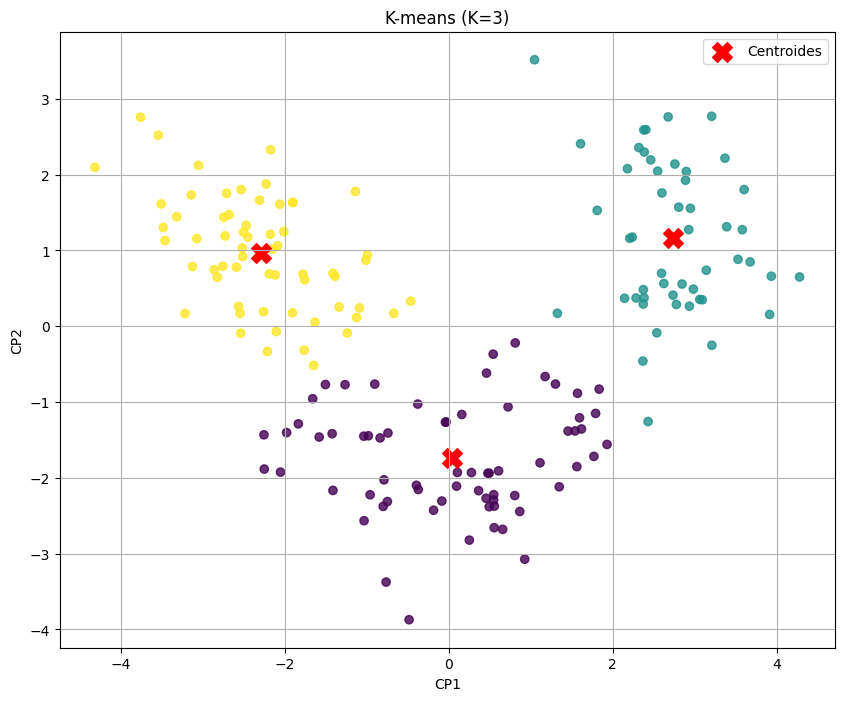

In [137]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Aplicar K-means con K=3
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(proyeccion)

# Visualizar resultados
plt.figure(figsize=(10, 8))
plt.scatter(proyeccion[:, 0], proyeccion[:, 1], c=cluster_labels, cmap='viridis', alpha=0.8)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            c='red', marker='X', s=200, label='Centroides')
plt.grid(True)
plt.xlabel('CP1')
plt.ylabel('CP2')
plt.title('K-means (K=3)')
plt.legend()
plt.show()

In [138]:
# Obtener todas las etiquetas únicas de especies
all_species = sorted(df['species'].unique())
print(f"Etiquetas únicas: {all_species}")

class_names = {
    'class_0': 'Barolo',
    'class_1': 'Grignolino',
    'class_2': 'Barbera'
}

# Crear dataframe con todas las especies
result = pd.DataFrame(index=all_species)

# Para cada cluster
for cluster_id in range(3):  # K=3 explícitamente
    # Inicializar columna para este cluster con ceros
    result[f'Cluster {cluster_id}'] = 0

    # Obtener índices de las muestras en este cluster
    cluster_indices = np.where(cluster_labels == cluster_id)[0]

    # Contar especies en este cluster
    for species in all_species:
        count = sum(df['species'].iloc[cluster_indices] == species)
        result.loc[species, f'Cluster {cluster_id}'] = count

result.index = result.index.map(lambda x: class_names.get(x, x))

print(result)

Etiquetas únicas: ['class_0', 'class_1', 'class_2']
            Cluster 0  Cluster 1  Cluster 2
Barolo              1          0         58
Grignolino         66          2          3
Barbera             0         48          0


Por lo que vemos, claramente el Cluster 0 cataloga a la especie Grgnolino, el Cluster 1 a la espacie Barbera y el Cluster 2 a la especie Barolo.


Dado que en verdad los datos estaban etiquetados vamos a presentar las distints métricas, accuracy_score, precision_score, recall_score, f1_score, classification_report, cohen_kappa_score

In [139]:
# Reconstruir las etiquetas verdaderas y predichas a partir de la matriz de confusión
# La matriz de confusión proporcionada:
conf_matrix = np.array([
    [1, 0, 58],    # Barolo (filas son verdaderas etiquetas)
    [66, 2, 3],    # Grignolino
    [0, 48, 0]     # Barbera
])

# Mapeo según tu asignación:
# Cluster 0 = Grignolino (índice 1)
# Cluster 1 = Barbera (índice 2)
# Cluster 2 = Barolo (índice 0)

# Reconstruir etiquetas verdaderas y predichas
y_true = []
y_pred = []

# Nombres de las clases
class_names = ['Barolo', 'Grignolino', 'Barbera']

# Recorrer la matriz de confusión para reconstruir las etiquetas
for true_idx, row in enumerate(conf_matrix):
    for pred_idx, count in enumerate(row):
        # Mapeo de índices de cluster a índices de clase
        cluster_to_class = {0: 1, 1: 2, 2: 0}  # Este mapeo viene de la asignación dada
        mapped_pred_idx = cluster_to_class[pred_idx]

        # Añadir las etiquetas tantas veces como indique el recuento
        y_true.extend([true_idx] * count)
        y_pred.extend([mapped_pred_idx] * count)

# Calcular las métricas
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
kappa = cohen_kappa_score(y_true, y_pred)

# Convertir índices a nombres de clase para el informe de clasificación
y_true_names = [class_names[i] for i in y_true]
y_pred_names = [class_names[i] for i in y_pred]

# Imprimir resultados
print("Accuracy: {:.4f}".format(accuracy))
print("Precision (weighted): {:.4f}".format(precision))
print("Recall (weighted): {:.4f}".format(recall))
print("F1 Score (weighted): {:.4f}".format(f1))
print("Cohen's Kappa: {:.4f}".format(kappa))
print("\nInforme de clasificación detallado:")
print(classification_report(y_true_names, y_pred_names))

# Reconstruir y mostrar la matriz de confusión reordenada
print("\nMatriz de confusión (filas: verdaderos, columnas: predichos):")
remapped_conf_matrix = np.zeros((3, 3), dtype=int)
for i in range(3):
    for j in range(3):
        cluster_to_class = {0: 1, 1: 2, 2: 0}
        remapped_conf_matrix[i, cluster_to_class[j]] = conf_matrix[i, j]

print(remapped_conf_matrix)

Accuracy: 0.9663
Precision (weighted): 0.9670
Recall (weighted): 0.9663
F1 Score (weighted): 0.9661
Cohen's Kappa: 0.9490

Informe de clasificación detallado:
              precision    recall  f1-score   support

     Barbera       0.96      1.00      0.98        48
      Barolo       0.95      0.98      0.97        59
  Grignolino       0.99      0.93      0.96        71

    accuracy                           0.97       178
   macro avg       0.97      0.97      0.97       178
weighted avg       0.97      0.97      0.97       178


Matriz de confusión (filas: verdaderos, columnas: predichos):
[[58  1  0]
 [ 3 66  2]
 [ 0  0 48]]


#Enfoque supervizado
#Random Forest y red neuronal
Se implementó un modelo Random Forest con etiquetado, utilizando el siguiente protocolo metodológico:

División del conjunto de datos (80% entrenamiento-validación, 20% prueba)
Aplicación de validación cruzada (cross-validation) en el conjunto de entrenamiento
Optimización de hiperparámetros mediante búsqueda exhaustiva

In [140]:
wineSupervizado = df
print(wineSupervizado.shape[0])

wineSupervizado = wineSupervizado.dropna()

print(wineSupervizado.shape[0])


178
178


División del conjunto de datos.


In [141]:
np.random.seed(31)

wineSupervizado = wineSupervizado.sample(frac=1, random_state=31)

In [142]:
#20% de los datos apra test test
X_train, X_test, y_train, y_test = train_test_split(
    wineSupervizado.drop('species', axis=1),
    wineSupervizado['species'],
    test_size=0.2,
    random_state=31
)

In [143]:
modelo = RandomForestClassifier(random_state=31)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20, None],
    'criterion': ['gini', 'entropy']
}

In [144]:
grid_search = GridSearchCV(
    estimator=modelo,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

In [145]:
#Buscar
grid_search.fit(X_train, y_train)
print("Búsqueda completada.")

#Mejores hiperparámetros encontrados
print("Mejores hiperparámetros:")
print(grid_search.best_params_)
print(f"Mejor puntuación de validación cruzada: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Búsqueda completada.
Mejores hiperparámetros:
{'criterion': 'gini', 'max_depth': 5, 'n_estimators': 100}
Mejor puntuación de validación cruzada: 0.9929


In [146]:
mejor_modelo = grid_search.best_estimator_

y_pred = mejor_modelo.predict(X_test)

In [147]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy en test: {accuracy:.4f}")

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

Accuracy en test: 0.9444

Reporte de clasificación:
              precision    recall  f1-score   support

     class_0       0.93      1.00      0.96        13
     class_1       1.00      0.87      0.93        15
     class_2       0.89      1.00      0.94         8

    accuracy                           0.94        36
   macro avg       0.94      0.96      0.94        36
weighted avg       0.95      0.94      0.94        36



El modelo tiene una efectividad de 0,9444.


##Análisis Comparativo de Modelos de Clasificación para Identificación de Vinos Metodología y Resultados

En este proyecto se implementaron dos enfoques distintos para la clasificación de vinos:
### Enfoque No Supervisado
Inicialmente, se desarrolló un modelo de clasificación utilizando técnicas no supervisadas, específicamente k-means en combinación con análisis de componentes principales (PCA). Este enfoque, que prescindió deliberadamente de las etiquetas de clase durante el entrenamiento, alcanzó una efectividad del 96% en el conjunto de evaluación.

###  Enfoque Supervisado
Posteriormente, se implementó un modelo Random Forest completamente supervisado, utilizando el siguiente protocolo metodológico:

División del conjunto de datos (80% entrenamiento-validación, 20% prueba)
Aplicación de validación cruzada (cross-validation) en el conjunto de entrenamiento

Optimización de hiperparámetros mediante búsqueda exhaustiva

El modelo supervisado tiene una efectividad inferior  0,944 evaluado en el conjunto de prueba independiente.

### Conclusiones
La comparación entre ambos enfoques revela un hallazgo interesante: la estructura intrínseca de los datos (captada por el modelo no supervisado) refleja casi perfectamente la clasificación establecida externamente. Las características químicas analizadas poseen un alto poder discriminativo, permitiendo separar eficazmente las clases incluso sin conocimiento previo de las etiquetas. La estructura natural de agrupamiento en los datos se alinea extraordinariamente bien con las categorías de vinos definidas, validando tanto la coherencia de la taxonomía establecida como la eficacia de las características seleccionadas para discriminar entre las diferentes clases.